In [2]:
#!/usr/bin/env python3.7

# Copyright 2020, Gurobi Optimization, LLC

# Solve the classic diet model, showing how to add constraints
# to an existing model.

import gurobipy as gp
from gurobipy import GRB


# Nutrition guidelines, based on
# USDA Dietary Guidelines for Americans, 2005
# http://www.health.gov/DietaryGuidelines/dga2005/

categories, minNutrition, maxNutrition = gp.multidict({
    'calories': [1800, 2200],
    'protein':  [91, GRB.INFINITY],
    'fat':      [0, 65],
    'sodium':   [0, 1779]})

foods, cost = gp.multidict({
    'hamburger': 2.49,
    'chicken':   2.89,
    'hot dog':   1.50,
    'fries':     1.89,
    'macaroni':  2.09,
    'pizza':     1.99,
    'salad':     2.49,
    'milk':      0.89,
    'ice cream': 1.59})

# Nutrition values for the foods
nutritionValues = {
    ('hamburger', 'calories'): 410,
    ('hamburger', 'protein'):  24,
    ('hamburger', 'fat'):      26,
    ('hamburger', 'sodium'):   730,
    ('chicken',   'calories'): 420,
    ('chicken',   'protein'):  32,
    ('chicken',   'fat'):      10,
    ('chicken',   'sodium'):   1190,
    ('hot dog',   'calories'): 560,
    ('hot dog',   'protein'):  20,
    ('hot dog',   'fat'):      32,
    ('hot dog',   'sodium'):   1800,
    ('fries',     'calories'): 380,
    ('fries',     'protein'):  4,
    ('fries',     'fat'):      19,
    ('fries',     'sodium'):   270,
    ('macaroni',  'calories'): 320,
    ('macaroni',  'protein'):  12,
    ('macaroni',  'fat'):      10,
    ('macaroni',  'sodium'):   930,
    ('pizza',     'calories'): 320,
    ('pizza',     'protein'):  15,
    ('pizza',     'fat'):      12,
    ('pizza',     'sodium'):   820,
    ('salad',     'calories'): 320,
    ('salad',     'protein'):  31,
    ('salad',     'fat'):      12,
    ('salad',     'sodium'):   1230,
    ('milk',      'calories'): 100,
    ('milk',      'protein'):  8,
    ('milk',      'fat'):      2.5,
    ('milk',      'sodium'):   125,
    ('ice cream', 'calories'): 330,
    ('ice cream', 'protein'):  8,
    ('ice cream', 'fat'):      10,
    ('ice cream', 'sodium'):   180}

# Model
m = gp.Model("diet")

# Create decision variables for the foods to buy
buy = m.addVars(foods, name="buy")

# You could use Python looping constructs and m.addVar() to create
# these decision variables instead.  The following would be equivalent
#
# buy = {}
# for f in foods:
#   buy[f] = m.addVar(name=f)

# The objective is to minimize the costs
m.setObjective(buy.prod(cost), GRB.MINIMIZE)

# Using looping constructs, the preceding statement would be:
#
# m.setObjective(sum(buy[f]*cost[f] for f in foods), GRB.MINIMIZE)

# Nutrition constraints
m.addConstrs((gp.quicksum(nutritionValues[f, c] * buy[f] for f in foods)
             == [minNutrition[c], maxNutrition[c]]
             for c in categories), "_")

# Using looping constructs, the preceding statement would be:
#
# for c in categories:
#  m.addRange(sum(nutritionValues[f, c] * buy[f] for f in foods),
#             minNutrition[c], maxNutrition[c], c)


        
def printSolution():
    if m.status == GRB.OPTIMAL:
        buyx = m.getAttr('x', buy)
        for f in foods:
            if buy[f].x > 0.0001:
                print('%s %g' % (f, buyx[f]))
    else:
        print('No solution')

# Solve
m.optimize()
print("****************************************************************")
printSolution()
print('\nAdding constraint: at most 6 servings of dairy')
m.addConstr(buy.sum(['milk', 'ice cream']) <= 6, "limit_dairy")

# Solve
#m.optimize()
#printSolution()

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (win64)
Optimize a model with 4 rows, 12 columns and 39 nonzeros
Model fingerprint: 0x33ddb849
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [9e-01, 3e+00]
  Bounds range     [7e+01, 2e+03]
  RHS range        [7e+01, 2e+03]
Presolve removed 0 rows and 2 columns
Presolve time: 0.00s
Presolved: 4 rows, 10 columns, 37 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.472500e+02   0.000000e+00      0s
       4    1.1828861e+01   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.00 seconds
Optimal objective  1.182886111e+01
****************************************************************

Cost: 11.8289

Buy:
hamburger 0.604514
milk 6.97014
ice cream 2.59132

Adding constraint: at most 6 servings of dairy


<gurobi.Constr *Awaiting Model Update*>

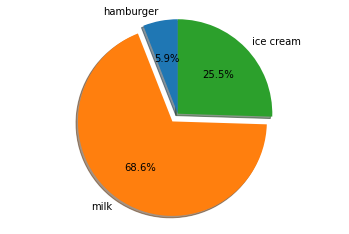

In [12]:
import matplotlib.pyplot as plt


if m.status == GRB.OPTIMAL:
    buyx = m.getAttr('x', buy)
    labels=[]
    sizes=[]
    explodelist=[]
    max=-1
    i=0
    for f in foods:
        if buy[f].x > 0.0001:
            labels.append(f)
            sizes.append(buyx[f])
            explodelist.append(0)
            i +=1
            if buyx[f]> max:
                maxi=i-1
                max=buyx[f]
    explodelist[maxi]=0.1
    explode=tuple(explodelist)
                  

#labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
#sizes = [15, 30, 45, 10]
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()